In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#### Performance evaluation of the Rancher (Kubernetes) HPC cluster with parallel simulation workloads.

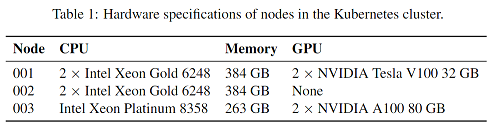

- The study starts with 1 simulation instance, then doubling the number of simulation instances every 5 minutes until maximum limit of 128, i.e., 8 batches: {1,2,4,8,16,32,64,128}.
- Takes about a minute for all instances in a batch to spin up -- so not exactly 5 mins all across.
- The study was conducted on Nodes 001 (2x V100), 003 (2x A100), 004 (2x A100) and 005 (4x A100) (refer Table 1), which each V100 time-sliced into 8 segments per card, and each A100 time-sliced into 14 segments per card resulting in a total of 128 GPU replicas.

In [2]:
# Define data directory
data_dir = 'data/hpc_stress_test_4_node_data'

In [3]:
# Define headers in the CSV files
headers = ['Node Name','CPU Cores','CPU Usage (%)','Memory Usage (MiB)','Memory Usage (%)','GPU Index','GPU Name','GPU Usage (%)','GPU Memory Usage (%)','GPU Memory Total (MiB)','GPU Memory Usage (MiB)','GPU Power Usage (W)']

# Read each CSV file in data directory
logs = []
for file in sorted(Path(data_dir).glob("hpc_metrics_*.csv")):
    logs.append(pd.read_csv(file, skiprows=1, names=headers))

# View the first 5 entries in the first dataframe
logs[0].head()

,Node Name,CPU Cores,CPU Usage (%),Memory Usage (MiB),Memory Usage (%),GPU Index,GPU Name,GPU Usage (%),GPU Memory Usage (%),GPU Memory Total (MiB),GPU Memory Usage (MiB),GPU Power Usage (W)
0,tw0005.dev.rcd.clemson.edu,1981,0,12100,1,0,NVIDIA A100-SXM4-40GB,0,0,40960,1844,51.06
1,tw0005.dev.rcd.clemson.edu,2801,1,13070,1,0,NVIDIA A100-SXM4-40GB,0,0,40960,2012,49.98
2,tw0005.dev.rcd.clemson.edu,2801,1,13070,1,0,NVIDIA A100-SXM4-40GB,0,0,40960,2014,49.98
3,tw0005.dev.rcd.clemson.edu,2227,0,15029,1,0,NVIDIA A100-SXM4-40GB,0,0,40960,2120,146.71
4,tw0005.dev.rcd.clemson.edu,2227,0,15029,1,0,NVIDIA A100-SXM4-40GB,38,0,40960,2131,142.77


In [4]:
# Extract separation bounds of different dataframes
bounds = [0]
for log in logs:
    bounds.append(bounds[-1] + max(log.index))
bounds = bounds[1:]
bounds

[59, 178, 417, 656, 895, 1134, 1373, 1612]

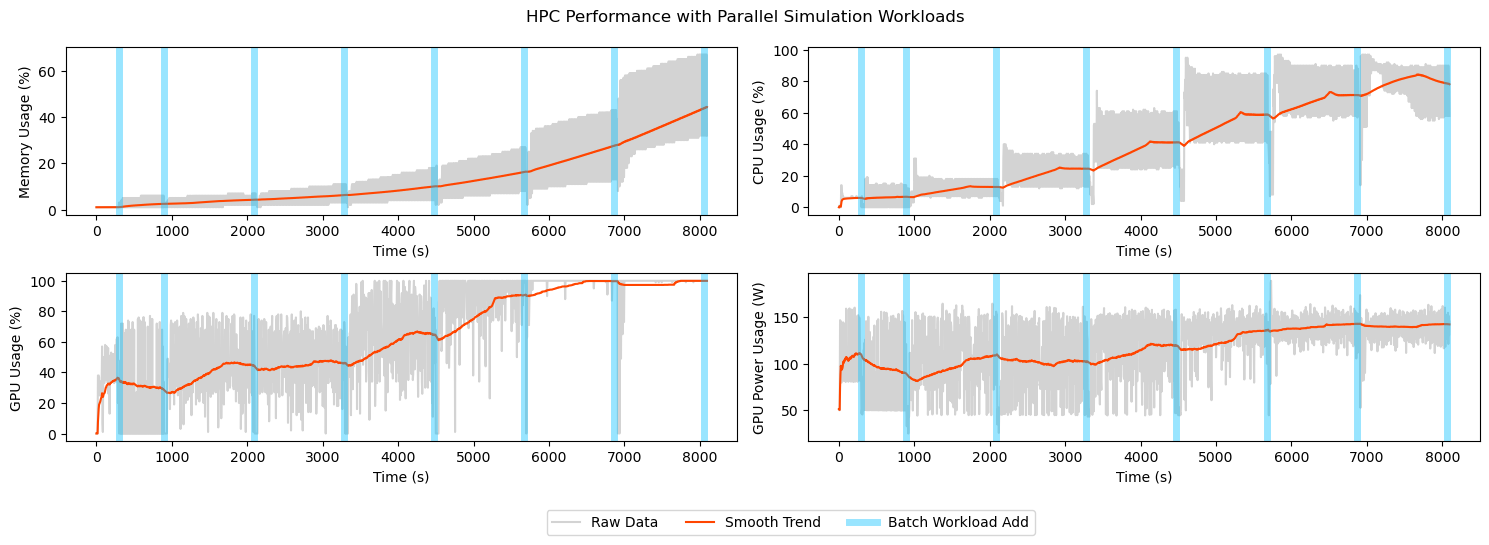

In [5]:
# Visualize the data

# Set figure size and sub-plot grid
fig = plt.figure(figsize=(15, 5))
fig.suptitle("HPC Performance with Parallel Simulation Workloads")
G = gridspec.GridSpec(2, 2)

# Concatenate all dataframes into a single one
concatenated_log = pd.concat([df.reset_index(drop=True).reset_index(drop=False) for df in logs], ignore_index=True)

# Plot Y-position vs. X-position
axes_1 = plt.subplot(G[0, 0])
axes_1.plot(5*concatenated_log.index, concatenated_log['Memory Usage (%)'], color='lightgray')
axes_1.plot(5*concatenated_log.index, concatenated_log['Memory Usage (%)'].rolling(window=250, min_periods=1).mean(), color='orangered')
for bound in bounds:
    axes_1.axvline(x=5*bound, color='deepskyblue', alpha=0.4, linewidth=5.0)
axes_1.set_xlabel(r"Time (s)")
axes_1.set_ylabel(r"Memory Usage (%)")

# Plot AEB Trigger vs. Timestamp
axes_2 = plt.subplot(G[0, 1])
axes_2.plot(5*concatenated_log.index, concatenated_log['CPU Usage (%)'], color='lightgray')
axes_2.plot(5*concatenated_log.index, concatenated_log['CPU Usage (%)'].rolling(window=150, min_periods=1).mean(), color='orangered')
for bound in bounds:
    axes_2.axvline(x=5*bound, color='deepskyblue', alpha=0.4, linewidth=5.0)
axes_2.set_xlabel(r"Time (s)")
axes_2.set_ylabel(r"CPU Usage (%)")

# Plot DTC vs. Timestamp
axes_3 = plt.subplot(G[1, 0])
axes_3.plot(5*concatenated_log.index, concatenated_log['GPU Usage (%)'], color='lightgray')
axes_3.plot(5*concatenated_log.index, concatenated_log['GPU Usage (%)'].rolling(window=150, min_periods=1).mean(), color='orangered')
for bound in bounds:
    axes_3.axvline(x=5*bound, color='deepskyblue', alpha=0.4, linewidth=5.0)
axes_3.set_xlabel(r"Time (s)")
axes_3.set_ylabel(r"GPU Usage (%)")

# Plot Collision Count vs. Timestamp
axes_4 = plt.subplot(G[1, 1])
axes_4.plot(5*concatenated_log.index, concatenated_log['GPU Power Usage (W)'], color='lightgray')
axes_4.plot(5*concatenated_log.index, concatenated_log['GPU Power Usage (W)'].rolling(window=150, min_periods=1).mean(), color='orangered')
for bound in bounds:
    axes_4.axvline(x=5*bound, color='deepskyblue', alpha=0.4, linewidth=5.0)
axes_4.set_xlabel(r"Time (s)")
axes_4.set_ylabel(r"GPU Power Usage (W)")

# Show the plot
plt.tight_layout()
plt.legend(['Raw Data', 'Smooth Trend', 'Batch Workload Add'], loc='lower left', bbox_to_anchor=(-0.4, -0.6), ncols=3)
plt.show()